# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 005


## Due: October 10, 2024

### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class. Randomly initialize the weight parameters for your network.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points according to the label your classifier would assign them. For instance, if a sample point $x$ is classified as class = 1, then color the point blue, otherwise color the point orange.

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects your solution.

e) Try at least two different learning schedules. For instance, you can start with a constant learning rate and see how that converges. Then, you can repeat everything by using a learning schedule that decays with time.

f) Try choosing your own loss function (**without asking me or the TAs what you should choose**), repeating (d).

g) Now try with three input features, generating your own training and testing data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a test set in the same manner as the training set, classify the samples, and compute the classification accuracy.

h) Using your data from HW1 or any new data you curate if you don't think your HW1 data is appropriate for this assighnment, train your MLP using your training set (80%). Compute the error rate on your test set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 50%, e=10%, f=10%, g=10%, h=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [4]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.863796,0.788154,0.0
1,0.219847,-0.033866,0.0
2,0.010129,0.786288,1.0
3,-0.081657,1.016638,1.0
4,-0.172649,0.056355,0.0


Let's message this data into a numpy format.

In [5]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [6]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

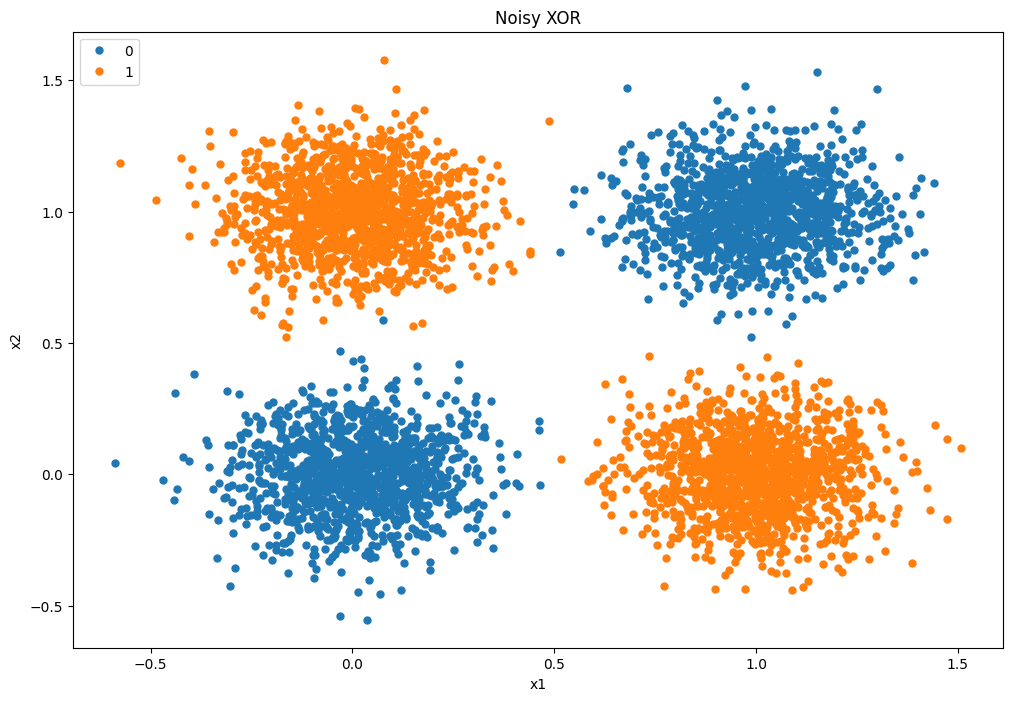

In [7]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

### backup: Working version - not mini batches & entropy

Epoch 0, Loss: 1.094781804731263
Epoch 100, Loss: 0.48617234894316264
Epoch 200, Loss: 0.3374079807266587
Epoch 300, Loss: 0.23042084121331535
Epoch 400, Loss: 0.16677101583390244
Epoch 500, Loss: 0.1297953739728964
Epoch 600, Loss: 0.10726993671728796
Epoch 700, Loss: 0.09255023930708364
Epoch 800, Loss: 0.08232193955091138
Epoch 900, Loss: 0.07486665746537842


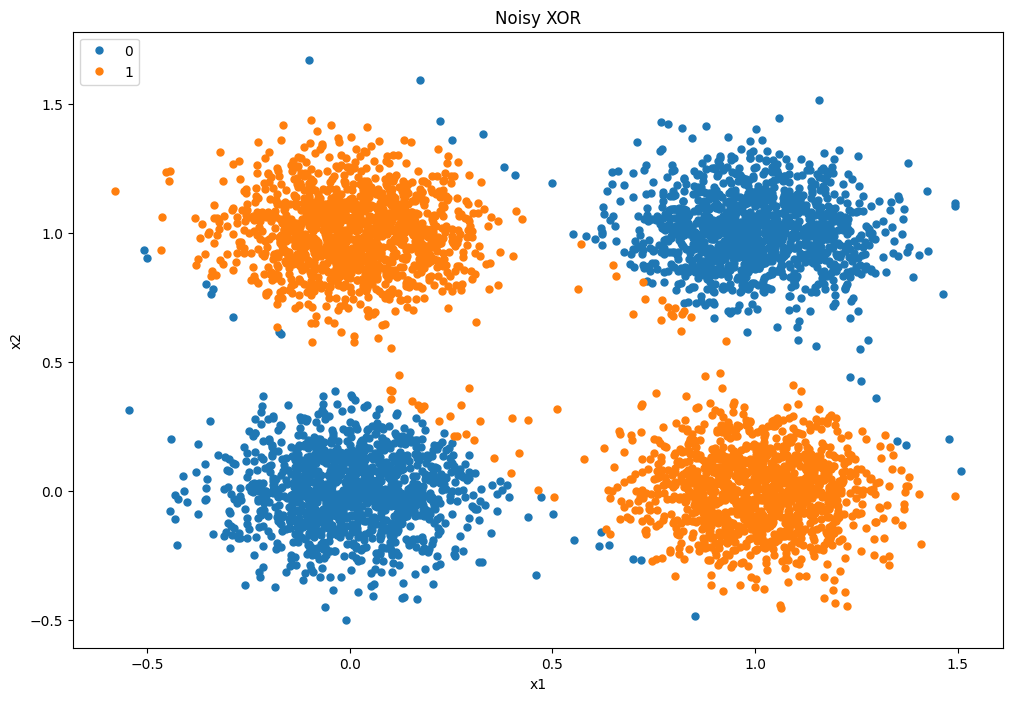

In [8]:
# import numpy as np
# import random
# import pandas as pd
# import matplotlib.pyplot as plt

# # Data generation code (same as before)
# data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
# for i in range(len(data.index)):
#     x1 = 1.0 * random.randint(0, 1)
#     x2 = 1.0 * random.randint(0, 1)
#     y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
#     x1 = x1 + 0.15 * np.random.normal()
#     x2 = x2 + 0.15 * np.random.normal()
#     data.iloc[i, 0] = x1
#     data.iloc[i, 1] = x2
#     data.iloc[i, 2] = y
        
# cols = data.shape[1]
# X = data.iloc[:, 0:cols - 1].values
# y = data.iloc[:, cols - 1:cols].values

# # Sloppy function for plotting our data
# def plot_data(X, y_prob):
    
#     fig, ax = plt.subplots(figsize=(12,8))
#     ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#     y_predict = y_prob > 0.5
#     indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
#     indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

#     ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
#     ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

#     ax.legend()
#     ax.legend(loc=2)
#     ax.set_xlabel('x1')
#     ax.set_ylabel('x2')
#     ax.set_title('Noisy XOR')
#     plt.show()

# # Initialize weights and biases
# input_size = 2
# hidden_size = 6
# output_size = 1

# # Random initialization of weights and biases
# np.random.seed(42)
# W1 = np.random.randn(input_size, hidden_size) # Weights from input to hidden
# b1 = np.zeros((1, hidden_size))               # Bias for hidden layer
# W2 = np.random.randn(hidden_size, output_size) # Weights from hidden to output
# b2 = np.zeros((1, output_size))               # Bias for output layer

# # Activation function (Sigmoid for output, ReLU for hidden)
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def relu(z):
#     return np.maximum(0, z)

# def sigmoid_derivative(z):
#     return z * (1 - z)

# def relu_derivative(z):
#     return np.where(z > 0, 1, 0)

# def forward_propagation(X, W1, b1, W2, b2):
#     # Hidden layer computation
#     Z1 = np.dot(X, W1) + b1  # Weighted sum at hidden layer
#     A1 = relu(Z1)            # Activation for hidden layer (ReLU)

#     # Output layer computation
#     Z2 = np.dot(A1, W2) + b2  # Weighted sum at output layer
#     A2 = sigmoid(Z2)          # Activation for output layer (Sigmoid)

#     return Z1, A1, A2

# # Backward propagation
# def backward_propagation(X, y, Z1, A1, A2, W2): 
#     m = X.shape[0]  # Number of examples

#     # Compute the derivative for output layer
#     dZ2 = A2 - y                   # Error at output layer
#     dW2 = (1 / m) * np.dot(A1.T, dZ2)  # Gradient for W2
#     db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1)) # Gradient for b2

#     # Backpropagate the error to hidden layer
#     dA1 = np.dot(dZ2, W2.T)        # Error propagated to hidden layer
#     dZ1 = np.multiply(dA1, relu_derivative(Z1))  # Apply ReLU derivative using Z1

#     dW1 = (1 / m) * np.dot(X.T, dZ1)  # Gradient for W1
#     db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))  # Reshape for db1

#     return dW1, db1, dW2, db2

# # Update weights and biases
# def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
#     W1 -= learning_rate * dW1
#     b1 -= learning_rate * db1
#     W2 -= learning_rate * dW2
#     b2 -= learning_rate * db2

#     return W1, b1, W2, b2

# # Training loop
# def train(X, y, W1, b1, W2, b2, learning_rate, epochs):
#     for i in range(epochs):
#         # Forward propagation
#         Z1, A1, A2 = forward_propagation(X, W1, b1, W2, b2)

#         # Clip A2 to avoid log(0) errors
#         A2 = np.clip(A2, 1e-10, 1 - 1e-10)

#         # # Compute the loss (binary cross-entropy)
#         loss = -np.mean(np.multiply(y, np.log(A2)) + np.multiply(1 - y, np.log(1 - A2)))

#         # compute loss - 
#         # In the training loop
#         # loss = compute_loss(y, A2)

#         # Backward propagation
#         dW1, db1, dW2, db2 = backward_propagation(X, y, Z1, A1, A2, W2)

#         # Update parameters
#         W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

#         # Print the loss every 100 epochs
#         if i % 100 == 0:
#             print(f'Epoch {i}, Loss: {loss}')

#     return W1, b1, W2, b2

# # Set hyperparameters
# learning_rate = 0.1
# epochs = 1000

# # Train the network
# W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs)

# # Make predictions
# _, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# # Plot the data and predictions
# plot_data(X, y_prob)



### Mini batches + soft plus + accuracy + boundaries

Epoch 0, Loss: 0.6824, Accuracy: 100.00%
Epoch 100, Loss: 0.6957, Accuracy: 100.00%
Epoch 200, Loss: 0.6928, Accuracy: 100.00%
Epoch 300, Loss: 0.6819, Accuracy: 100.00%
Epoch 400, Loss: 0.6918, Accuracy: 100.00%
Epoch 500, Loss: 0.6936, Accuracy: 100.00%
Epoch 600, Loss: 0.6962, Accuracy: 100.00%
Epoch 700, Loss: 0.6980, Accuracy: 100.00%
Epoch 800, Loss: 0.6919, Accuracy: 100.00%
Epoch 900, Loss: 0.6834, Accuracy: 100.00%


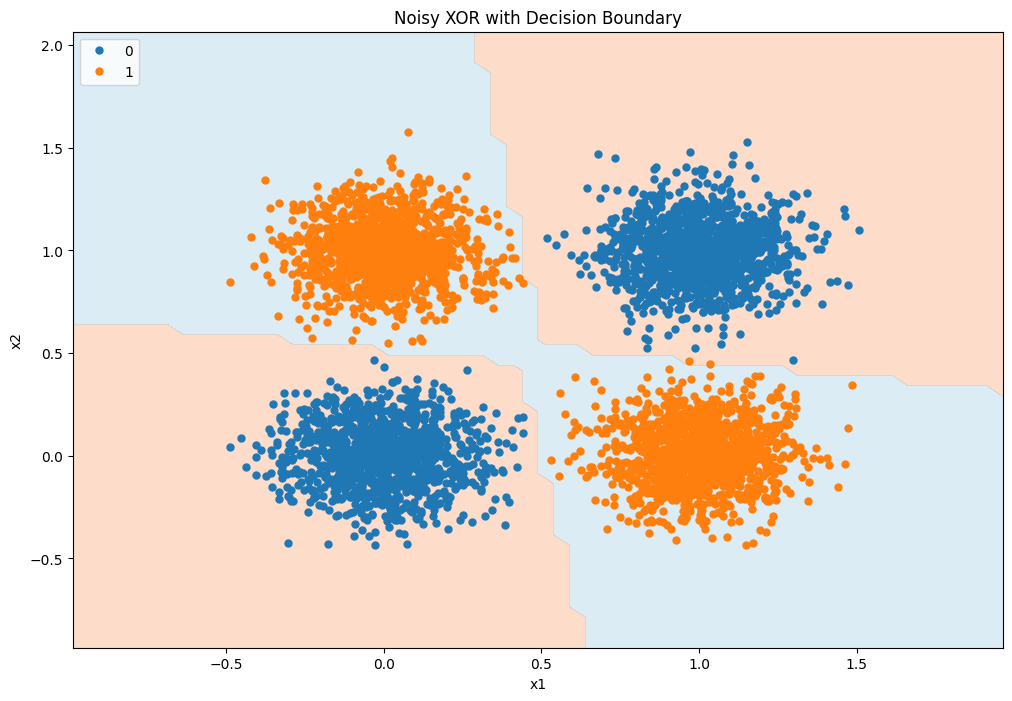

In [14]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Data generation code (same as before)
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i, 0] = x1
    data.iloc[i, 1] = x2
    data.iloc[i, 2] = y
    
        
cols = data.shape[1]
X = data.iloc[:, 0:cols - 1].values
y = data.iloc[:, cols - 1:cols].values

# Sloppy function for plotting our data
def plot_data(X, y_prob, W1, b1, W2, b2):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    # Plot the data points
    ax.plot(X[indices_0, 0], X[indices_0, 1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], marker='o', linestyle='', ms=5, label='1')

    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

    # Forward propagate on the grid points to get predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, Z = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z > 0.5  # Use threshold of 0.5 to classify

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary by coloring regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR with Decision Boundary')

    plt.show()

# Neural network code
input_size = 2
hidden_size = 6
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

def relu(z):
    return np.maximum(0, z)

def softplus(z):
    return np.log(1 + np.exp(z))

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softplus(Z2)
    return Z1, A1, A2

def backward_propagation(X, y, Z1, A1, A2, W2): 
    m = X.shape[0]
    dZ2 = A2 - y
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1))
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, (Z1 > 0).astype(int))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Training with mini-batch gradient descent
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    m = X.shape[0]
    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch training
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward propagation
            Z1, A1, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Calculate the Softplus loss
            loss = np.mean(softplus(A2 - y_batch))

            # Binary predictions
            predictions = (A2 > 0.5).astype(int)

            # Calculate accuracy
            accuracy = np.mean(predictions == y_batch) * 100

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print the loss and accuracy every 100 epochs
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    return W1, b1, W2, b2



# Set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 32  # You can adjust the batch size as needed

# Train the network
W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size)

# Make predictions
_, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# Plot the data and predictions
# plot_data(X, y_prob)
plot_data(X, y_prob, W1, b1, W2, b2)


### Mini batches + cross entropy + accuracy + boundaries

Epoch 0, Loss: 0.3887, Accuracy: 100.00%
Epoch 100, Loss: 0.0028, Accuracy: 100.00%
Epoch 200, Loss: 0.0329, Accuracy: 100.00%
Epoch 300, Loss: 0.0550, Accuracy: 100.00%
Epoch 400, Loss: 0.0031, Accuracy: 100.00%
Epoch 500, Loss: 0.0001, Accuracy: 100.00%
Epoch 600, Loss: 0.1418, Accuracy: 87.50%
Epoch 700, Loss: 0.0003, Accuracy: 100.00%
Epoch 800, Loss: 0.0045, Accuracy: 100.00%
Epoch 900, Loss: 0.0266, Accuracy: 100.00%


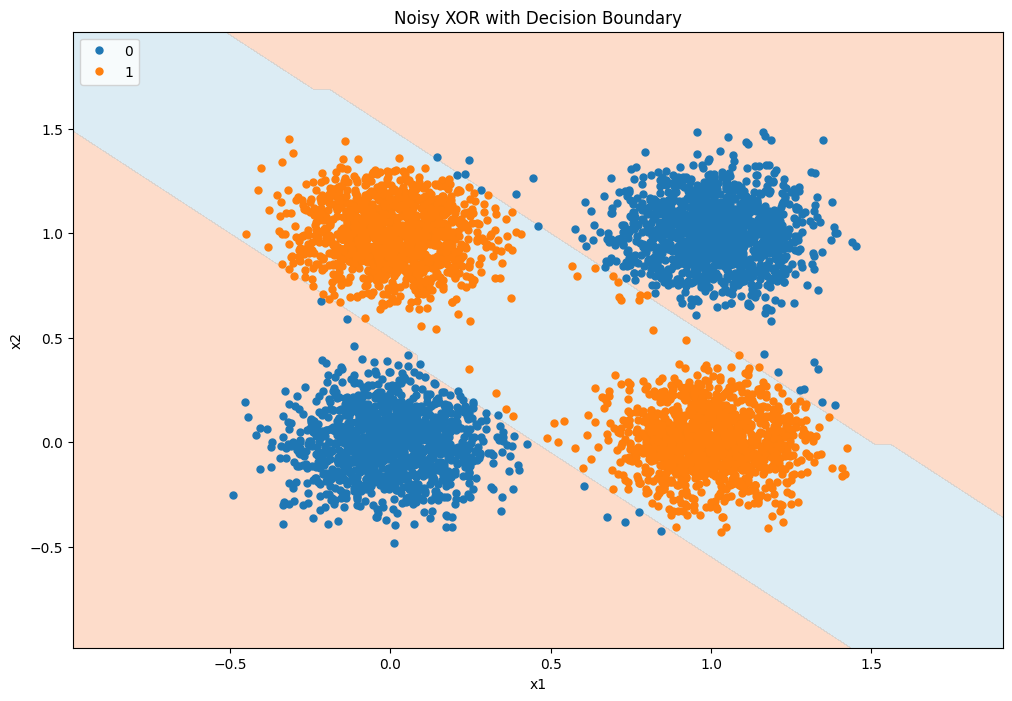

In [19]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Data generation code (same as before)
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i, 0] = x1
    data.iloc[i, 1] = x2
    data.iloc[i, 2] = y
    
        
cols = data.shape[1]
X = data.iloc[:, 0:cols - 1].values
y = data.iloc[:, cols - 1:cols].values

# Sloppy function for plotting our data
def plot_data(X, y_prob, W1, b1, W2, b2):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    # Plot the data points
    ax.plot(X[indices_0, 0], X[indices_0, 1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], marker='o', linestyle='', ms=5, label='1')

    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

    # Forward propagate on the grid points to get predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, Z = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z > 0.5  # Use threshold of 0.5 to classify

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary by coloring regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR with Decision Boundary')

    plt.show()

# Neural network code
input_size = 2
hidden_size = 6
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

# Replace softplus with sigmoid for output layer
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Modify the forward_propagation function to use sigmoid for A2
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)  # Use sigmoid for binary classification
    return Z1, A1, A2

# Add binary cross-entropy loss function
def binary_crossentropy_loss(A2, y):
    m = y.shape[0]
    loss = -(1/m) * np.sum(y * np.log(A2) + (1 - y) * np.log(1 - A2))
    return loss

# Update backward propagation to match the new activation and loss
def backward_propagation(X, y, Z1, A1, A2, W2):
    m = X.shape[0]
    dZ2 = A2 - y  # No change here since cross-entropy loss with sigmoid leads to this
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1))
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, (Z1 > 0).astype(int))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))
    return dW1, db1, dW2, db2

# Modify the training loop to calculate cross-entropy loss
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    m = X.shape[0]
    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch training
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward propagation
            Z1, A1, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Calculate the binary cross-entropy loss
            loss = binary_crossentropy_loss(A2, y_batch)

            # Binary predictions
            predictions = (A2 > 0.5).astype(int)

            # Calculate accuracy
            accuracy = np.mean(predictions == y_batch) * 100

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print the loss and accuracy every 100 epochs
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    return W1, b1, W2, b2

# Set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 32

# Train the network
W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size)

# Make predictions
_, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# Plot the data and predictions
plot_data(X, y_prob, W1, b1, W2, b2)


### Mini batches + Softmax + accuracy + boundaries - hidden units: 3

Epoch 0, Loss: 0.8096, Accuracy: 75.00%
Epoch 100, Loss: 0.6895, Accuracy: 87.50%
Epoch 200, Loss: 0.6936, Accuracy: 87.50%
Epoch 300, Loss: 0.6519, Accuracy: 87.50%
Epoch 400, Loss: 0.6973, Accuracy: 100.00%
Epoch 500, Loss: 0.6535, Accuracy: 87.50%
Epoch 600, Loss: 0.7099, Accuracy: 87.50%
Epoch 700, Loss: 0.7104, Accuracy: 100.00%
Epoch 800, Loss: 0.6985, Accuracy: 100.00%
Epoch 900, Loss: 0.6850, Accuracy: 100.00%


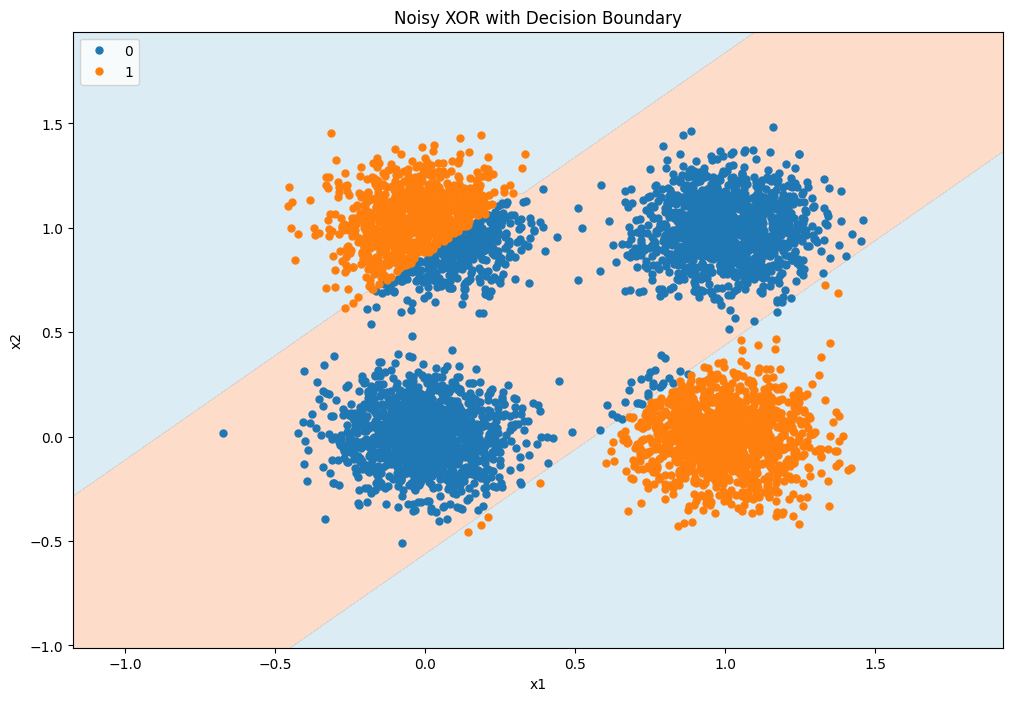

In [20]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Data generation code (same as before)
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i, 0] = x1
    data.iloc[i, 1] = x2
    data.iloc[i, 2] = y
    
        
cols = data.shape[1]
X = data.iloc[:, 0:cols - 1].values
y = data.iloc[:, cols - 1:cols].values

# Sloppy function for plotting our data
def plot_data(X, y_prob, W1, b1, W2, b2):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    # Plot the data points
    ax.plot(X[indices_0, 0], X[indices_0, 1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], marker='o', linestyle='', ms=5, label='1')

    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

    # Forward propagate on the grid points to get predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, Z = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z > 0.5  # Use threshold of 0.5 to classify

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary by coloring regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR with Decision Boundary')

    plt.show()

# Neural network code
input_size = 2
hidden_size = 3
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

def relu(z):
    return np.maximum(0, z)

def softplus(z):
    return np.log(1 + np.exp(z))

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softplus(Z2)
    return Z1, A1, A2

def backward_propagation(X, y, Z1, A1, A2, W2): 
    m = X.shape[0]
    dZ2 = A2 - y
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1))
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, (Z1 > 0).astype(int))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Training with mini-batch gradient descent
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    m = X.shape[0]
    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch training
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward propagation
            Z1, A1, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Calculate the Softplus loss
            loss = np.mean(softplus(A2 - y_batch))

            # Binary predictions
            predictions = (A2 > 0.5).astype(int)

            # Calculate accuracy
            accuracy = np.mean(predictions == y_batch) * 100

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print the loss and accuracy every 100 epochs
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    return W1, b1, W2, b2



# Set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 32  # You can adjust the batch size as needed

# Train the network
W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size)

# Make predictions
_, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# Plot the data and predictions
# plot_data(X, y_prob)
plot_data(X, y_prob, W1, b1, W2, b2)


### Mini batches + Softmax + accuracy + boundaries - hidden units: 512

Epoch 0, Loss: 0.7610, Accuracy: 100.00%
Epoch 100, Loss: 0.7025, Accuracy: 100.00%
Epoch 200, Loss: 0.6857, Accuracy: 100.00%
Epoch 300, Loss: 0.6915, Accuracy: 100.00%
Epoch 400, Loss: 0.6917, Accuracy: 100.00%
Epoch 500, Loss: 0.6963, Accuracy: 100.00%
Epoch 600, Loss: 0.6910, Accuracy: 100.00%
Epoch 700, Loss: 0.6930, Accuracy: 100.00%
Epoch 800, Loss: 0.6941, Accuracy: 100.00%
Epoch 900, Loss: 0.6919, Accuracy: 100.00%


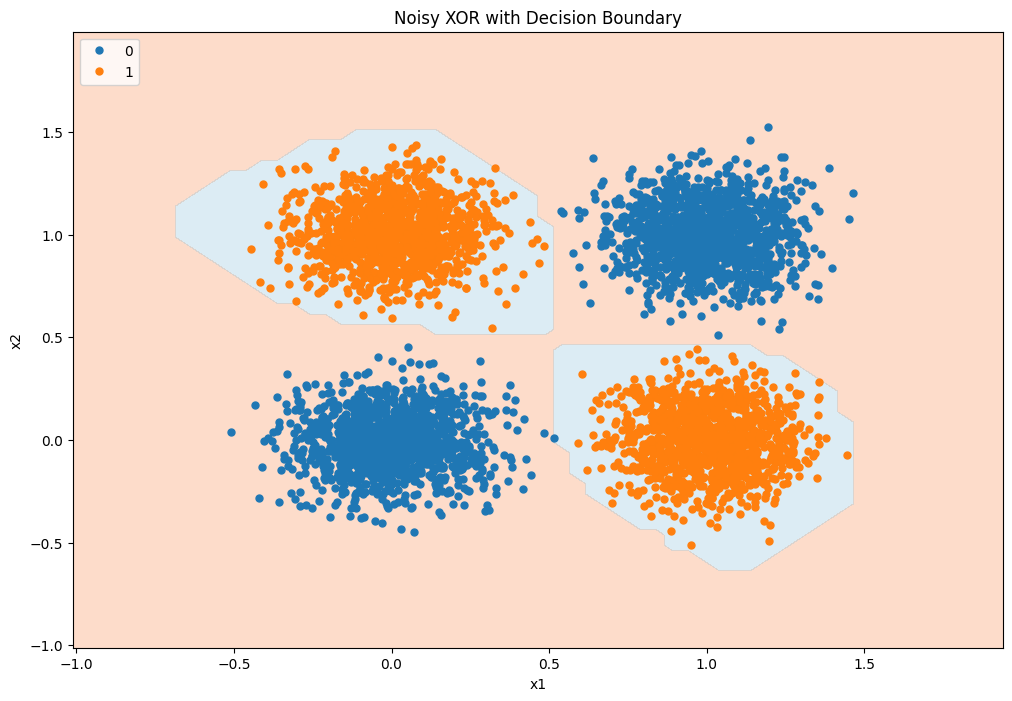

In [21]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Data generation code (same as before)
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i, 0] = x1
    data.iloc[i, 1] = x2
    data.iloc[i, 2] = y
    
        
cols = data.shape[1]
X = data.iloc[:, 0:cols - 1].values
y = data.iloc[:, cols - 1:cols].values

# Sloppy function for plotting our data
def plot_data(X, y_prob, W1, b1, W2, b2):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    # Plot the data points
    ax.plot(X[indices_0, 0], X[indices_0, 1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], marker='o', linestyle='', ms=5, label='1')

    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

    # Forward propagate on the grid points to get predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, Z = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z > 0.5  # Use threshold of 0.5 to classify

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary by coloring regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR with Decision Boundary')

    plt.show()

# Neural network code
input_size = 2
hidden_size = 512
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

def relu(z):
    return np.maximum(0, z)

def softplus(z):
    return np.log(1 + np.exp(z))

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softplus(Z2)
    return Z1, A1, A2

def backward_propagation(X, y, Z1, A1, A2, W2): 
    m = X.shape[0]
    dZ2 = A2 - y
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1))
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, (Z1 > 0).astype(int))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Training with mini-batch gradient descent
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    m = X.shape[0]
    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch training
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward propagation
            Z1, A1, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Calculate the Softplus loss
            loss = np.mean(softplus(A2 - y_batch))

            # Binary predictions
            predictions = (A2 > 0.5).astype(int)

            # Calculate accuracy
            accuracy = np.mean(predictions == y_batch) * 100

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print the loss and accuracy every 100 epochs
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

    return W1, b1, W2, b2



# Set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 32  # You can adjust the batch size as needed

# Train the network
W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size)

# Make predictions
_, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# Plot the data and predictions
# plot_data(X, y_prob)
plot_data(X, y_prob, W1, b1, W2, b2)


### Different learning schedules - constant learning rate and slow decay

Epoch 0, Loss: 0.6642, Accuracy: 100.00%
Epoch 100, Loss: 0.6907, Accuracy: 100.00%
Epoch 200, Loss: 0.6929, Accuracy: 100.00%
Epoch 300, Loss: 0.6752, Accuracy: 100.00%
Epoch 400, Loss: 0.6943, Accuracy: 100.00%
Epoch 500, Loss: 0.7137, Accuracy: 100.00%
Epoch 600, Loss: 0.6878, Accuracy: 100.00%
Epoch 700, Loss: 0.6896, Accuracy: 100.00%
Epoch 800, Loss: 0.6930, Accuracy: 100.00%
Epoch 900, Loss: 0.6918, Accuracy: 100.00%


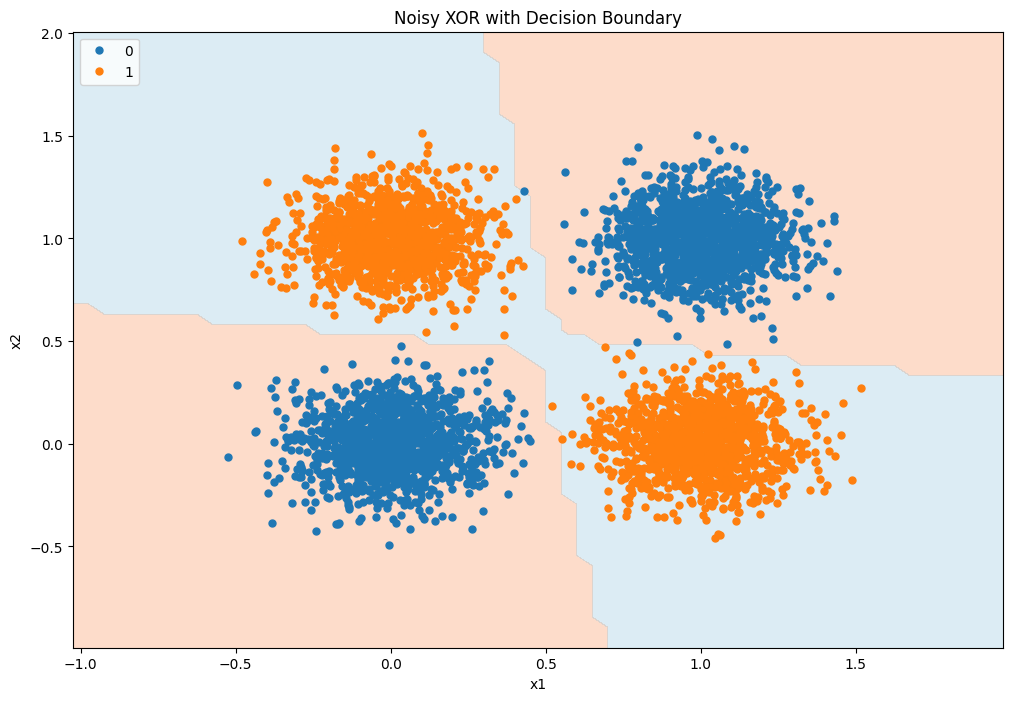

Epoch 0, Loss: 0.6535, Accuracy: 100.00%
Epoch 100, Loss: 0.6856, Accuracy: 100.00%
Epoch 200, Loss: 0.6934, Accuracy: 100.00%
Epoch 300, Loss: 0.6879, Accuracy: 100.00%
Epoch 400, Loss: 0.6836, Accuracy: 100.00%
Epoch 500, Loss: 0.6951, Accuracy: 100.00%
Epoch 600, Loss: 0.6935, Accuracy: 100.00%
Epoch 700, Loss: 0.6931, Accuracy: 100.00%
Epoch 800, Loss: 0.6937, Accuracy: 100.00%
Epoch 900, Loss: 0.6966, Accuracy: 100.00%


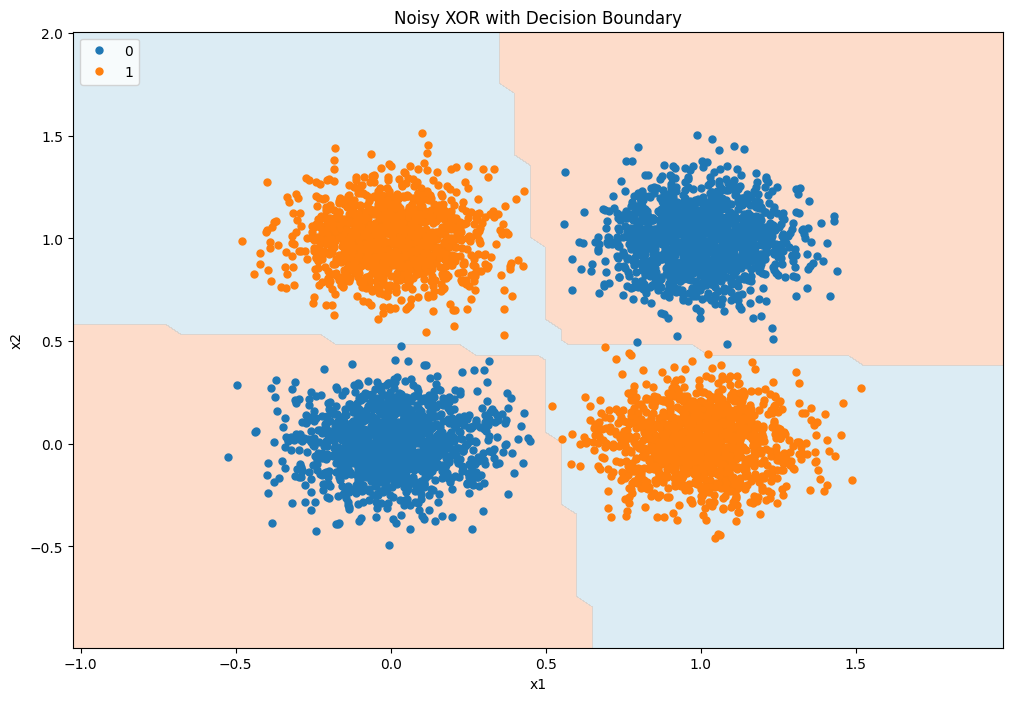

In [25]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Data generation code (same as before)
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    y = 1.0 * np.logical_xor(x1 == 1, x2 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i, 0] = x1
    data.iloc[i, 1] = x2
    data.iloc[i, 2] = y
    
        
cols = data.shape[1]
X = data.iloc[:, 0:cols - 1].values
y = data.iloc[:, cols - 1:cols].values

# Sloppy function for plotting our data
def plot_data(X, y_prob, W1, b1, W2, b2):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    # Plot the data points
    ax.plot(X[indices_0, 0], X[indices_0, 1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], marker='o', linestyle='', ms=5, label='1')

    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

    # Forward propagate on the grid points to get predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, Z = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z > 0.5  # Use threshold of 0.5 to classify

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary by coloring regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Set labels and title
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR with Decision Boundary')

    plt.show()

# Neural network code
input_size = 2
hidden_size = 6
output_size = 1

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

def relu(z):
    return np.maximum(0, z)

def softplus(z):
    return np.log(1 + np.exp(z))

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softplus(Z2)
    return Z1, A1, A2

def backward_propagation(X, y, Z1, A1, A2, W2): 
    m = X.shape[0]
    dZ2 = A2 - y
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1))
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, (Z1 > 0).astype(int))
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Training with mini-batch gradient descent
def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size, decay=False):
    m = X.shape[0]
    losses = []
    accuracies = []

    decay_rate = 0.96  # Rate for learning rate decay
    decay_steps = 100  # How often to apply decay

    for i in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Update learning rate if using decay
        if decay:
            lr = learning_rate * (decay_rate ** (i // decay_steps))
        else:
            lr = learning_rate


        # Mini-batch training
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward propagation
            Z1, A1, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Calculate the Softplus loss
            loss = np.mean(softplus(A2 - y_batch))

            # Binary predictions
            predictions = (A2 > 0.5).astype(int)

            # Calculate accuracy
            accuracy = np.mean(predictions == y_batch) * 100

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, A2, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Learning rate decay
        if decay and i % 100 == 0 and i > 0:
            learning_rate *= 0.9  # Decay the learning rate by 10%

        losses.append(loss)
        accuracies.append(accuracy)

        # Print the loss and accuracy every 100 epochs
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, Learning Rate: {lr:.6f}')

    return W1, b1, W2, b2, losses, accuracies

# Set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 32  # You can adjust the batch size as needed

# Train the network with a constant learning rate
print("Training with Constant Learning Rate:")
W1_const, b1_const, W2_const, b2_const = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size, decay=False)


# Make predictions
_, _, y_prob_const = forward_propagation(X, W1_const, b1_const, W2_const, b2_const)

# Reset weights for the next training
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

# Train the network with a decaying learning rate
W1_decay, b1_decay, W2_decay, b2_decay, losses_decay, accuracies_decay = train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size, decay=True)

# Make predictions
_, _, y_prob_decay = forward_propagation(X, W1_decay, b1_decay, W2_decay, b2_decay)
